<a href="https://colab.research.google.com/github/fengfrankgthb/BUS-41204/blob/main/Reinforcement%20Learning/SimpleBlackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Reinforcement Learning Example - Blackjack

Here, we're going to use Q-learning to "solve" infinite deck blackjack. Pretending there are infinite decks means that card counting is irrelevant, which really reduces the state space.

We consider a simple action space where the player can only choose to *hit* (get another card) or *stand* (stay with the current total in hand).

We also abstract from betting and just try to figure out how to win. Each hand will have three possible outcomes: win (with reward = 1), draw (with reward = 0), and lose (with reward = -1).

We will make the environment simple. If the player hits and ends up with a total greater than 21, the player immediately loses. If the player stands before reaching 21, the dealer must play until having cards totalling at least 17. If the dealer draws a card producing a total more than 21 or has a total smaller than the player's total, the player wins. If the dealer and player both have the same total, the game ends in a draw.

With these rules in mind, the state space the player needs to keep track of consists of just three things: the sum of the player's cards (12-21), the dealer's card (1-10), and whether the player has a useable ace (aces can count as 1 or 11). This gives only 200 possible states - which is a pretty manageable state space.


# Python libraries

As usual, we'll start by importing the libraries we'll use.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


# Functions

We're now going to define the functions we will need to solve our blackjack game using *Q-learning*.

We start by defining the environment and rules of the game.

In [2]:
class BlackjackEnv:
    def __init__(self):
        self.action_space = [0, 1]  # 0 = Stick, 1 = Hit
        self.reset()

    def reset(self):
        """Initialize a new round with a random player's hand and dealer's upcard."""
        self.player_sum = 0
        self.usable_ace = False
        self.dealer_card = self.draw_card()  # Dealer's first card
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.player_sum, self.usable_ace = self.evaluate_hand(self.player_hand)
        return (self.dealer_card, self.player_sum, self.usable_ace)

    def draw_card(self):
        """Draws a card from an infinite deck (1-10, face cards as 10)."""
        card = random.randint(1, 13)
        return min(card, 10)

    def evaluate_hand(self, hand):
        """Calculates hand value and determines if there is a usable ace."""
        total = sum(hand)
        usable_ace = 1 in hand and total + 10 <= 21
        if usable_ace:
            total += 10
        return total, usable_ace

    def step(self, action):
        """Performs action in the environment (hit or stick)."""
        if action == 1:  # Hit
            self.player_hand.append(self.draw_card())
            self.player_sum, self.usable_ace = self.evaluate_hand(self.player_hand)
            if self.player_sum > 21:
                return (self.dealer_card, self.player_sum, self.usable_ace), -1, True  # Player bust
            return (self.dealer_card, self.player_sum, self.usable_ace), 0, False

        # Stick: Dealer's turn
        dealer_hand = [self.dealer_card, self.draw_card()]
        dealer_sum, _ = self.evaluate_hand(dealer_hand)

        while dealer_sum < 17:
            dealer_hand.append(self.draw_card())
            dealer_sum, _ = self.evaluate_hand(dealer_hand)

        # Determine reward
        if dealer_sum > 21 or self.player_sum > dealer_sum:
            return (self.dealer_card, self.player_sum, self.usable_ace, dealer_hand, dealer_sum), 1, True  # Win
        elif dealer_sum == self.player_sum:
            return (self.dealer_card, self.player_sum, self.usable_ace, dealer_hand, dealer_sum), 0, True  # Draw
        else:
            return (self.dealer_card, self.player_sum, self.usable_ace, dealer_hand, dealer_sum), -1, True  # Loss



For fun - and to check that the environment works correctly - we have a little interactive game where we can play hands of blackjack.

To play the game interactively, uncomment the statement

`play_blackjack()`

or enter it into a new code block.

In [3]:
def play_blackjack():
    env = BlackjackEnv()
    state = env.reset()
    dealer_card, player_sum, usable_ace = state

    print("\nWelcome to Blackjack! ")
    print(f"Dealer's visible card: {dealer_card}")
    print(f"Your hand: {env.player_hand} (Sum: {player_sum}, Usable Ace: {usable_ace})")

    done = False
    while not done:
        action = input("Enter 'h' to Hit or 's' to Stick: ").strip().lower()
        if action == 'h':
            state, reward, done = env.step(1)
            dealer_card, player_sum, usable_ace = state
            print(f"\nYou drew a card. Your new sum: {player_sum}, Usable Ace: {usable_ace}")
            print(f"Your hand: {env.player_hand}")
            if done:
                print("\n💥 You busted! Dealer wins. 💥")
        elif action == 's':
            state, reward, done = env.step(0)
            dealer_card, player_sum, usable_ace, dealer_hand, dealer_sum = state
            print("\n🛑 You chose to stick.")
            print(f"Dealer's full hand: {dealer_hand} (Final sum: {dealer_sum})")
            done = True

        if done:
            if reward == 1:
                print("\n🎉 You won! Congratulations! 🎉")
            elif reward == 0:
                print("\n😐 It's a draw.")
            else:
                print("\n😞 You lost. Better luck next time!")

# Uncomment play_blackjack() to actually play hand
# Start interactive game
# play_blackjack()

The next two functions will be used to visualize the results after we run the learning algorithm. They will allow us to plot the *state-value function* which captures the expected reward of being in any given state and the *optimal action* which is the optimal action for any given state learned by the model.

In [4]:
# State-value function and optimal strategy from RL results
def compute_state_value_function(q_table):
    state_values_usable_ace = np.zeros((10, 10))  # Player sum 12-21, Dealer card 1-10
    state_values_no_usable_ace = np.zeros((10, 10))

    for dealer_card in range(1, 11):
        for player_sum in range(12, 22):  # Player sum range 12-21
            for usable_ace in [True, False]:
                state = (dealer_card, player_sum, usable_ace)
                if state in q_table:
                    best_action_value = max(q_table[state])  # Best action's Q-value
                    if usable_ace:
                        state_values_usable_ace[player_sum - 12, dealer_card - 1] = best_action_value
                    else:
                        state_values_no_usable_ace[player_sum - 12, dealer_card - 1] = best_action_value

    return state_values_usable_ace, state_values_no_usable_ace

def compute_optimal_strategy(q_table):
    optimal_strategy_usable_ace = np.zeros((10, 10))  # Player sum 12-21, Dealer card 1-10
    optimal_strategy_no_usable_ace = np.zeros((10, 10))

    for dealer_card in range(1, 11):
        for player_sum in range(12, 22):  # Player sum range 12-21
            for usable_ace in [True, False]:
                state = (dealer_card, player_sum, usable_ace)
                if state in q_table:
                    best_action = np.argmax(q_table[state])  # 0 = Stick, 1 = Hit
                    if usable_ace:
                        optimal_strategy_usable_ace[player_sum - 12, dealer_card - 1] = best_action
                    else:
                        optimal_strategy_no_usable_ace[player_sum - 12, dealer_card - 1] = best_action

    return optimal_strategy_usable_ace, optimal_strategy_no_usable_ace

The final utility function will just be for plotting the state-value function and optimal action.

In [5]:
def plot_blackjack_values(state_values_usable_ace, state_values_no_usable_ace,
                          optimal_strategy_usable_ace, optimal_strategy_no_usable_ace):
    """
    Plots the state-value function and optimal strategy for blackjack.

    Parameters:
    state_values_usable_ace (numpy.ndarray): State-value function with a usable ace.
    state_values_no_usable_ace (numpy.ndarray): State-value function without a usable ace.
    optimal_strategy_usable_ace (numpy.ndarray): Optimal strategy with a usable ace.
    optimal_strategy_no_usable_ace (numpy.ndarray): Optimal strategy without a usable ace.
    """
    # Plot State-Value Function
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    titles = ["State-Value Function (Usable Ace)", "State-Value Function (No Usable Ace)"]
    data = [state_values_usable_ace, state_values_no_usable_ace]

    for ax, title, values in zip(axes, titles, data):
        cax = ax.matshow(values, cmap="coolwarm", aspect="auto", origin='lower')
        fig.colorbar(cax, ax=ax)
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))
        ax.set_yticks(range(10))
        ax.set_yticklabels(range(12, 22))
        ax.set_xlabel("Dealer's Card", labelpad=10)
        ax.set_ylabel("Player's Sum")
        ax.xaxis.set_label_position('bottom')
        ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
        ax.set_title(title)

    plt.show()

    # Plot Optimal Strategy
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    titles = ["Optimal Strategy (Usable Ace)", "Optimal Strategy (No Usable Ace)"]
    data = [optimal_strategy_usable_ace, optimal_strategy_no_usable_ace]

    for ax, title, values in zip(axes, titles, data):
        cax = ax.matshow(values, cmap="coolwarm", aspect="auto", origin='lower')
        fig.colorbar(cax, ax=ax)
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))
        ax.set_yticks(range(10))
        ax.set_yticklabels(range(12, 22))
        ax.set_xlabel("Dealer's Card", labelpad=10)
        ax.set_ylabel("Player's Sum")
        ax.xaxis.set_label_position('bottom')
        ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
        ax.set_title(title)

    plt.show()


Finally, we define the Q-learning algorithm.

Essentiall, the algorithm works by



1.   Making an initial guess for $Q(s,a)$ - the expected reward for taking action $a$ when the state is $s$
2.   Repeating the following updating strategy *episodes* number of times:


*   Start a hand of blackjack and observe initial state (i.e. see the player's and dealer's hand)
*   Choose the action $a \in \{hit,stand\}$ to take using $\varepsilon$-greedy action choice
*   Perform action $a$, receive reward $r$, and see new state $s'$
*   Update the Q-value function according to $Q(s,a) = Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$ for learning rate $\alpha < 1$ and discount factor $\gamma < 1$.
*   Keep going until hand ends with win/loss/draw.





In [6]:
class QLearningAgentWithDecay:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon_start=1.0, epsilon_min=0.1, episodes=200000):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_min = epsilon_min
        self.episodes = episodes
        self.q_table = {}  # (dealer_card, player_sum, usable_ace) -> [Q(stick), Q(hit)]
        self.win_rates = []  # Store win rates over training

        # Calculate decay rate to reach epsilon_min at 3/4 of episodes
        self.decay_rate = np.power(epsilon_min / epsilon_start, 1 / (0.75 * episodes))
        self.epsilon = epsilon_start

    def get_q_values(self, state):
        """Returns Q-values for a given state, initializing if unseen."""
        if state not in self.q_table:
            self.q_table[state] = [0.0, 0.0]  # Initialize Q-values to neutral exploration
        return self.q_table[state]

    def choose_action(self, state):
        """Epsilon-greedy action selection."""
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        return np.argmax(self.get_q_values(state))

    def update_q(self, state, action, reward, next_state, done):
        """Performs the Q-learning update."""
        q_values = self.get_q_values(state)
        if done:
            q_values[action] += self.alpha * (reward - q_values[action])
        else:
            next_q_values = self.get_q_values(next_state)
            q_values[action] += self.alpha * (reward + self.gamma * max(next_q_values) - q_values[action])

    def evaluate(self, env, num_games=1000):
        """Evaluates agent's win rate over a set number of games."""
        wins = 0
        for _ in range(num_games):
            state = env.reset()
            done = False
            while not done:
                action = np.argmax(self.get_q_values(state))  # Always pick best action
                state, reward, done = env.step(action)
            if reward == 1:
                wins += 1
        return wins / num_games

    def train(self, env, eval_interval=5000):
        """Trains the agent using Q-learning and tracks win rate."""
        for episode in range(self.episodes):
            state = env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = env.step(action)
                self.update_q(state, action, reward, next_state, done)
                state = next_state

            # Decay epsilon
            if episode < 0.75 * self.episodes:
                self.epsilon *= self.decay_rate
                self.epsilon = max(self.epsilon, self.epsilon_min)

            if episode % eval_interval == 0:
                win_rate = self.evaluate(env, 1000)
                self.win_rates.append(win_rate)
                print(f"Episode {episode}, Win Rate: {win_rate:.2f}, Epsilon: {self.epsilon:.4f}")


# Run the algorithm

We now run the agent. For the results reported in the notes, we use 4 million episodes. Using this many episodes takes more time than one might want to use in class. It's not horrible though if you want to give it a try.

In [7]:
random.seed(2725)

# Train the Q-learning agent and track win rates
qd2_eval_int = 50000 # For demonstration, set to 1000
qd2_ep = 4000000     # For demonstration, set to 10000
env = BlackjackEnv()
qd2_agent = QLearningAgentWithDecay(alpha=0.001, gamma=0.9, epsilon_min=0.01, episodes=qd2_ep)
qd2_agent.train(env, eval_interval=qd2_eval_int)

Episode 0, Win Rate: 0.37, Epsilon: 1.0000
Episode 50000, Win Rate: 0.43, Epsilon: 0.9261
Episode 100000, Win Rate: 0.42, Epsilon: 0.8577
Episode 150000, Win Rate: 0.43, Epsilon: 0.7943
Episode 200000, Win Rate: 0.42, Epsilon: 0.7356
Episode 250000, Win Rate: 0.45, Epsilon: 0.6813
Episode 300000, Win Rate: 0.42, Epsilon: 0.6310
Episode 350000, Win Rate: 0.44, Epsilon: 0.5843
Episode 400000, Win Rate: 0.43, Epsilon: 0.5412
Episode 450000, Win Rate: 0.45, Epsilon: 0.5012
Episode 500000, Win Rate: 0.43, Epsilon: 0.4642
Episode 550000, Win Rate: 0.44, Epsilon: 0.4299
Episode 600000, Win Rate: 0.45, Epsilon: 0.3981
Episode 650000, Win Rate: 0.39, Epsilon: 0.3687
Episode 700000, Win Rate: 0.44, Epsilon: 0.3415
Episode 750000, Win Rate: 0.41, Epsilon: 0.3162
Episode 800000, Win Rate: 0.44, Epsilon: 0.2929
Episode 850000, Win Rate: 0.41, Epsilon: 0.2712
Episode 900000, Win Rate: 0.45, Epsilon: 0.2512
Episode 950000, Win Rate: 0.44, Epsilon: 0.2326
Episode 1000000, Win Rate: 0.42, Epsilon: 0.21

Let's plot the win rate as we move along episodes. We see there's a fair amount of variability, but it looks like the RL player is winning 40-45% of hands. (Note that in casinos [the player wins about 42% of hands](https://www.winstar.com/blog/blackjack-odds/).)

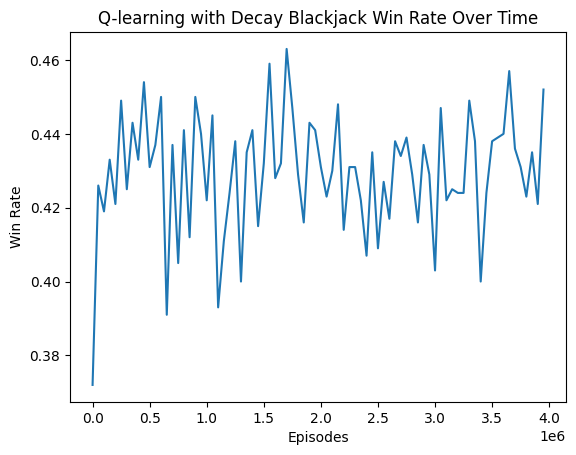

In [8]:
# Plot win rates over training
plt.plot(range(0, len(qd2_agent.win_rates) * qd2_eval_int, qd2_eval_int), qd2_agent.win_rates)
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.title("Q-learning with Decay Blackjack Win Rate Over Time")
plt.show()

Finally, let's plot the value function and look at the strategy learned by our RL agent.

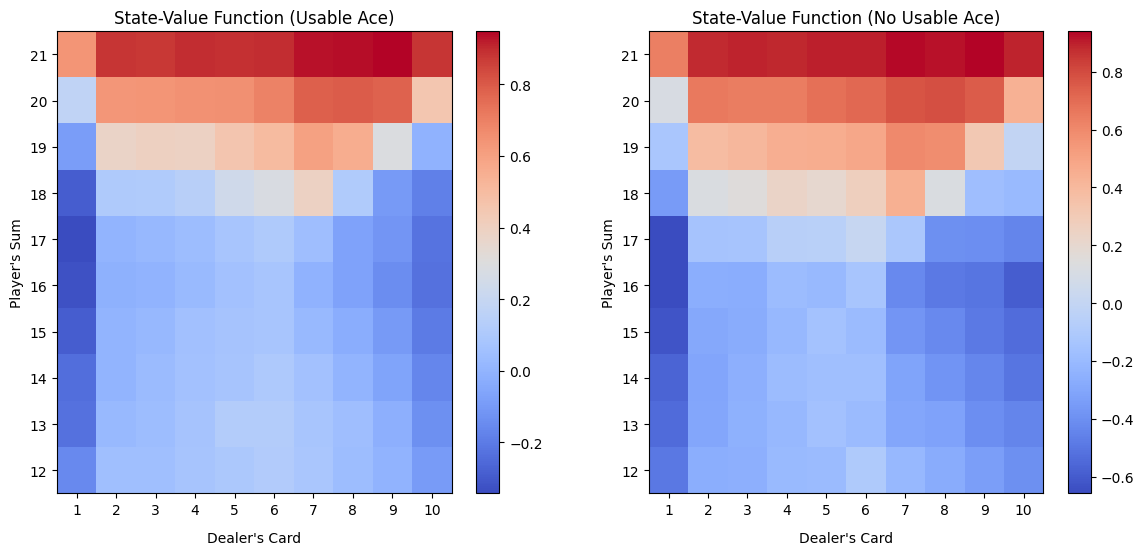

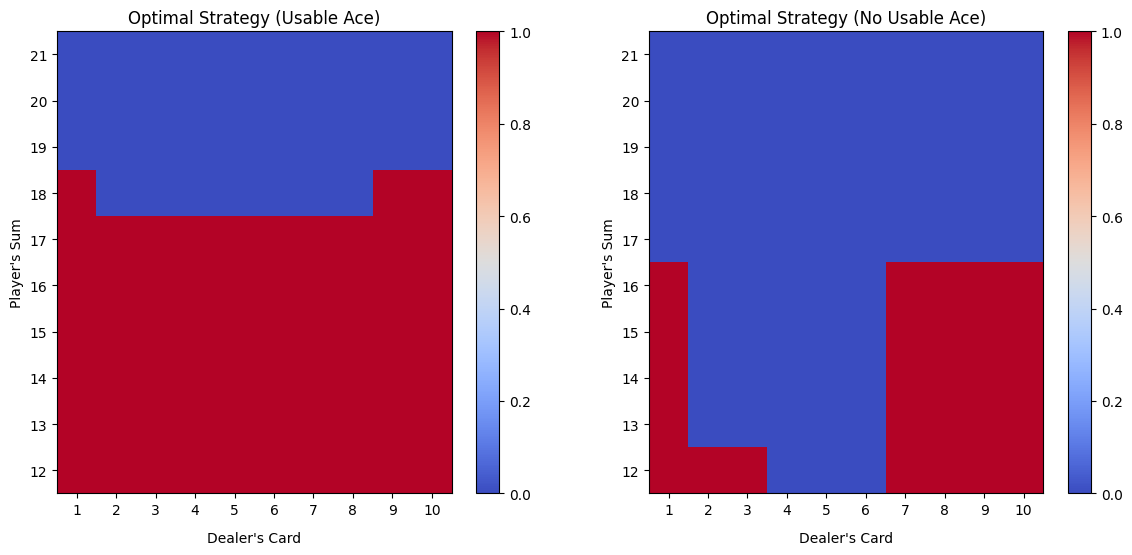

In [9]:
# Compute the state-value function and optimal strategy
qd2_state_values_usable_ace, qd2_state_values_no_usable_ace = compute_state_value_function(qd2_agent.q_table)
qd2_optimal_strategy_usable_ace, qd2_optimal_strategy_no_usable_ace = compute_optimal_strategy(qd2_agent.q_table)

plot_blackjack_values(qd2_state_values_usable_ace, qd2_state_values_no_usable_ace,
                          qd2_optimal_strategy_usable_ace, qd2_optimal_strategy_no_usable_ace)

Note that the optimal strategy here is basically the classic "basic" strategy of Thorp (1966) *Beat the Dealer*.